# Applying a Entailemnt Internalization

In [1]:
import pandas as pd
import numpy as np
import scipy.stats
import matplotlib.pyplot as plt
from IPython.display import HTML, display
# import joypy
from matplotlib.ticker import PercentFormatter
import seaborn as sns
import warnings
from lr.plot.myplots import plot_error_bar
warnings.filterwarnings("ignore", category=RuntimeWarning)
warnings.filterwarnings("ignore", category=UserWarning)

# load data

In [2]:
result_path = "results/snli_lr_Tfidf_ent_int_60.csv"
# result_path = "results/snli_lr_Tfidf_ent_int_10.csv"
# result_path = "results/snli_lr_Tfidf_ent_int_30_40.csv"




# ent_result_path = "results/snli_lr_Tfidf_ent_int_ent_25_25.csv"
# neutral_result_path = "results/snli_lr_Tfidf_ent_int_neutral_25_25.csv"
# contra_result_path = "results/snli_lr_Tfidf_ent_int_contra_25_25.csv"
result = pd.read_csv(result_path)

In [3]:
print("shape = {}\n".format(result.shape))
# print("total simulation time = {:.3f} minutes\n".format(result.training_time.sum() / 60 ))
display(HTML(result.head(3).to_html()))

shape = (1680, 12)



,pcts,acc,acct,acc_minus_acct,t1,C,D,E,F,t2,pos_trans_rate,neg_trans_rate
0,0.01,0.617862,0.616237,0.001626,0.502440,5566,515,499,3262,0.252465,0.492110,0.507890
1,0.01,0.614712,0.615830,-0.001118,-0.372277,5619,431,442,3350,0.138603,0.506300,0.493700
2,0.01,0.613696,0.613595,0.000102,0.033387,5591,449,448,3354,0.001115,0.499443,0.500557


## Accuracy

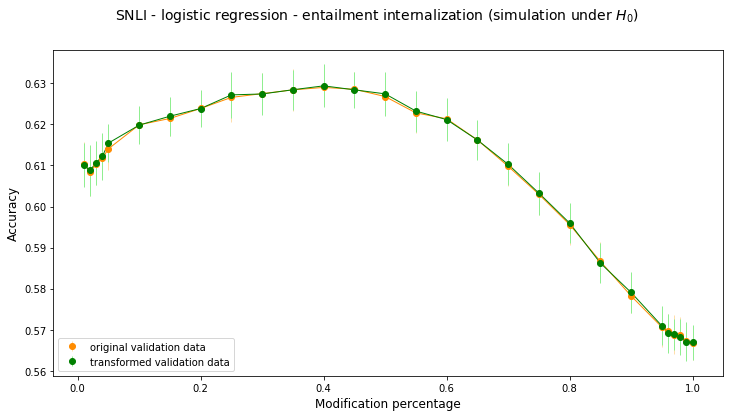

In [4]:
title = r'SNLI - logistic regression - entailment internalization (simulation under $H_0$)'

acc = result.groupby("pcts").mean()[["acc"]].values.flatten()
e_acc = result.groupby("pcts").std()[["acc"]].values.flatten()
x = result.groupby("pcts").mean().index 

acc_t = result.groupby("pcts").mean()[["acct"]].values.flatten()
e_acc_t = result.groupby("pcts").std()[["acct"]].values.flatten()


fig, ax = plt.subplots(1, 1, figsize=(12,6))

plot_error_bar(x=x,
               y=acc,
               yerr=e_acc,
               color1="darkorange",
               color2='navajowhite',
               label="original validation data")
plot_error_bar(x=x,
               y=acc_t,
               yerr=e_acc_t,
               color1="green",
               color2='lightgreen',
               label="transformed validation data")
fig.suptitle(title, fontsize=14);
ax.set_xlabel("Modification percentage", fontsize=12);
ax.set_ylabel("Accuracy", fontsize=12);
plt.legend(loc="lower left");

# Paired t-test (simulation)

## Type 1 error

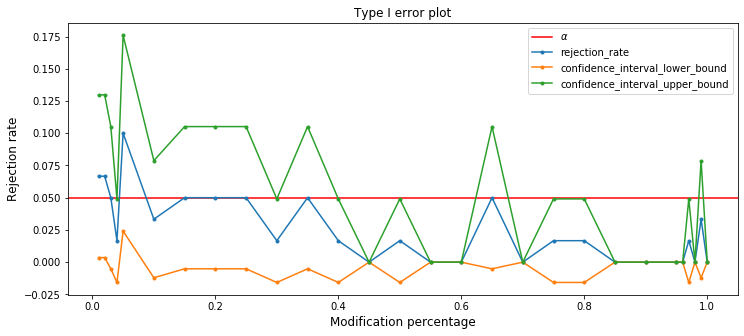

In [5]:
alpha_t_test = 0.05
alpha_ci = 0.05 
z_alpha_2 =  scipy.stats.norm.ppf(1  - (alpha_ci/2))
B = result.pcts.value_counts().unique()
assert B.shape[0] == 1
B = B[0]

result.loc[:, "p_values"]  = 1 - scipy.stats.chi2.cdf(result.t1 ** 2, df=1)
result.loc[:, "paired_t_test"] = (result.p_values < alpha_t_test).astype(int)
rejection_rate = result.groupby("pcts").mean().paired_t_test
rejection_rate.name = "rejection_rate"
std = z_alpha_2 * np.sqrt((rejection_rate * (1 - rejection_rate))/ B)

l = rejection_rate - std
l.name = "confidence_interval_lower_bound"
u = rejection_rate + std
u.name = "confidence_interval_upper_bound"
df_rr = pd.DataFrame([rejection_rate, l,u]).transpose()




fig, ax = plt.subplots(1,1,figsize=(12,5))
plt.axhline(y=alpha_t_test, color='r', linestyle='-', label=r"$\alpha$")
df_rr.plot(ax=ax, title="Type I error plot", style='.-');
ax.set_xlabel("Modification percentage", fontsize=12);
ax.set_ylabel(r"Rejection rate", fontsize=12);
plt.legend(loc="best");

## P-values frequency

,[0.0 - 0.01],[0.01 - 0.02],[0.02 - 0.03],[0.03 - 0.04],[0.04 - 0.05]
count,28.000000,28.000000,28.000000,28.000000,28.000000
mean,0.004167,0.002976,0.005952,0.005952,0.006548
std,0.008636,0.006500,0.010358,0.012184,0.013099
min,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.000000,0.000000,0.000000,0.000000,0.000000
75%,0.000000,0.000000,0.016667,0.000000,0.004167
max,0.033333,0.016667,0.033333,0.033333,0.050000


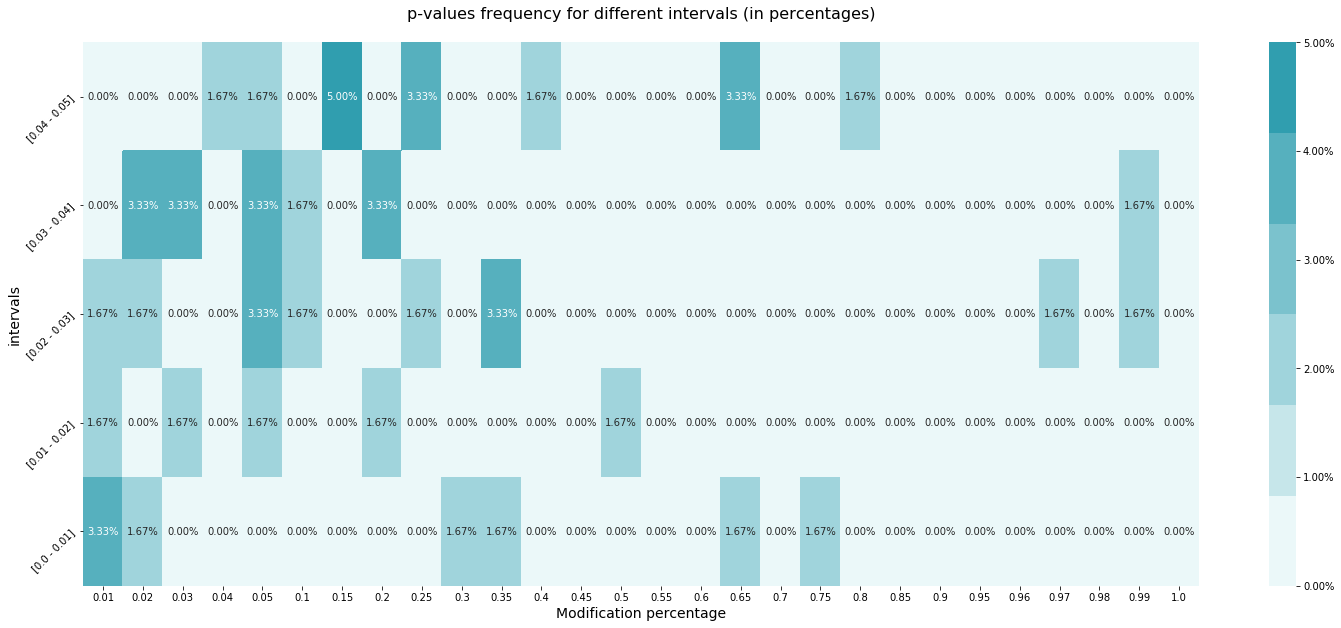

In [8]:
pcts = result.pcts.unique()
df = result.set_index("pcts")
p_values_freqs = []
n = result.pcts.value_counts().unique()[0]
space = np.array(range(0,6))/100
columns = []

for i,pc in enumerate(space):
    try:
        columns.append("[{} - {}]".format(pc, space[i+1]))
    except IndexError:
        pass

for rho in pcts:
    ps = df.loc[rho].p_values
#     n = 60
#     ps = np.random.uniform(0,1,n)
    
    p_values_freq = np.histogram(ps, bins=space)[0] / n
    p_values_freq = pd.DataFrame(p_values_freq).transpose()
    p_values_freq.index = [rho]
    p_values_freq.columns = columns
    p_values_freqs.append(p_values_freq)

freqs = pd.concat(p_values_freqs)

display(HTML(freqs.describe().to_html()))


cmap = sns.light_palette((210, 90, 60), input="husl")

fig, ax = plt.subplots(figsize=(25,10))
sns.heatmap(freqs[columns[::-1]].transpose(),cmap=cmap, cbar=True, annot=True, fmt='.2%');
cbar = ax.collections[0].colorbar
cbar.ax.yaxis.set_major_formatter(PercentFormatter(1, 2))
ax.set_xlabel("Modification percentage", fontsize=14);
ax.set_ylabel(r"intervals", fontsize=14);
ax.set_title("p-values frequency for different intervals (in percentages)\n", fontsize=16)
plt.yticks(rotation=45);
# fig.savefig("t.png")